# Assignment 9: Causal Inference (Part 2)

## Objective:

Causal inference is the process of drawing a conclusion about a causal connection based on the conditions of the occurrence of an effect. It is a very powerful and widely-used tool in real-world applications and scenarios. In this assignment, you are expected to apply the basic concepts of causal inference to solve problems on real datasets and be able to achieve the following goals.

* Understand why causality is needed.
* Understand what is causality, particularly the difference between causality and correlation.
* Understand how to estimate counterfactual results.
* Understand how to use the graphical model to represent causality.
* Can use some tools (e.g., dowhy) to infer causality, express causality and estimate treatment effects.

# 0. Preparation

In [14]:
import numpy as np
import pandas as pd
from dataprep.eda import plot
pd.options.mode.chained_assignment = None

In this assignment, you are going to use the [Lalonde](lalonde.csv) dataset. Each tuple in the dataset represents an individual who was enrolled (or not enrolled) in a job training program. It aims to evaluate the effectiveness of a job training program (the treatment variable) on the real earnings of an individual, after completing the program for years. 

The dataset consists of a number of demographic variables, like age, race, academic background, marriage status, and previous real earnings in 1974, 1975 as well as a treatment indicator, and the real earnings in the year 1978 (the outcome variable).

In [15]:
lalonde = pd.read_csv('lalonde.csv', index_col=0)
lalonde.head()
lalonde.head(-5)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899
...,...,...,...,...,...,...,...,...,...,...
PSID420,0,39,2,1,0,1,1,0.0,0.0,964.9555
PSID421,0,55,8,0,0,1,1,0.0,0.0,0.0000
PSID422,0,16,9,0,0,0,1,0.0,0.0,5551.8190


In [45]:
plot(lalonde)

GridBox(id='2204', ...)

## Task 1. Causal Graph 
In this task, you will draw a causal graph on a real-world dataset based on the information given. Please remind yourself of the difference between causality and correlation.

In [16]:
#import graphviz, the python tool we are going to use for this task
from graphviz import Digraph

In the Lalonde dataset, `treat` is the treatment attribute, which represents whether an individual was enrolled in the job training program or not. `re78` is the outcome attribute. `age` and `married` are confounding variables. Please draw the causal graph for these four attributes using Graphviz.

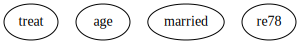

In [17]:
dot = Digraph(comment='The causal graph for Lalonde')
dot.node('a','treat')
dot.node('b','age')
dot.node('c','married')
dot.node('d','re78')

dot

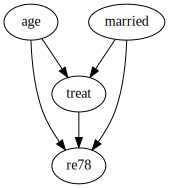

In [18]:
#<-- Write Your Code -->

#Implement your plot function here and show the graph, the output should be a causal graph
dot.edge('b','a')
dot.edge('b','d')
dot.edge('c','a')
dot.edge('c','d')
dot.edge('a','d')
dot


## Task 2. ATE Estimation
In this task, your job is to implement different AET estimation approaches and draw useful conclusions.

### 2.1 Perfect Matching
For the PSID tuples in the dataset (i.e., those individuals who weren't enrolled in the job training program), please use perfect matching to estimate their salaries if they received treatments?


In [19]:
#<-- Write Your Code -->

# Implement the perfect matching method here and output the count of PSID tuples whose counterfactual can be computed
# using perfect matching, as well as the percentage of such tuples among all PSID tuples. If there are multiple 
# tuples in the treatment group that can be matched with the control group, just select the first one
# output: count and percentage

# Defining treatment group and control group
control_grp = lalonde[lalonde["treat"] == 0]
treat_grp = lalonde[lalonde["treat"] == 1]

#Remove duplicate tuples from treatment group based on all covariates except treatment and outcome
treat_filt = treat_grp.drop_duplicates(subset={'age','educ','black','hispan','married','nodegree','re74','re75'}, keep='first')
#Join on all covariates except treatment and outcome variables
per_match = pd.merge(control_grp, treat_filt, on=['age','educ','black','hispan','married','nodegree','re74','re75'],how='inner')
per_match = per_match[['treat_x','age','educ','black','hispan','married','nodegree','re78_x','re78_y']]

#Obtain count and percentage
count = len(per_match)
percentage = (count/len(control_grp)) * 100

In [20]:
# Run the following code to print out the result
print("Count of tuples which can be computed by perfect matching is " + str(count))
print("Percentage of such tuples among all PSID tuples is " + str(percentage))

Count of tuples which can be computed by perfect matching is 12
Percentage of such tuples among all PSID tuples is 2.797202797202797


In [21]:
#<-- Write Your Code -->

# Compute ATE among those PSID tuples whose counterfactual can be computed using perfect matching
# output: value of ATE
# Calculate difference of salaries between treatment and control group
per_match["diff"] = per_match["re78_y"] - per_match["re78_x"]
# Obtain mean to form the ATE value
ATE = sum(per_match["diff"])/count


In [22]:
# Run following code to print the result
print("ATE by perfect matching is " + str(ATE))

ATE by perfect matching is 1362.3939999999998


### 2.2 Nearest Neighbor Matching
For the PSID tuples in the dataset (i.e., those who weren't enrolled in the job training program), please use the nearest neighbor matching to estimate their salaries if they received treatments?

Please use all covariates (the attributes besides treatment and outcome) and use Euclidean distance as the distance metric.

### Important Note:  Two approaches have been followed to accomplish same task. As discussed with Yi and professor, I am putting both approaches below to accomplish nearest neghbour matching

#### Below is Approach 1 to find Nearest Neighbour using looping. 
Kindly note that we will not get a single ATE value on all implementation because for a single PSID we can have multiple records whose outcome values are different with same euclidean distance. Here we are taking the first eligible record and its outcome value

In [27]:
# Defining treatment group and control group
control_grp1 = lalonde[lalonde["treat"] == 0]
treat_grp1 = lalonde[lalonde["treat"] == 1]
df_dist = pd.DataFrame(columns=['cnt_idx','trt_idx,','distance','diff'])
counter = 0
#Looping over control group
for cnt_idx, cnt_row in control_grp1.iterrows():
    flag = 'first'
#Looping through treatment group
    for trt_idx,trt_row in treat_grp1.iterrows():
        #Finding euclidean distance
        norm = np.linalg.norm(cnt_row[['age','educ','black','hispan','married','nodegree','re74','re75']].values - trt_row[['age','educ','black','hispan','married','nodegree','re74','re75']].values)
        # Taking first record as optimal distance for further check
        if flag == 'first':
            distance = norm
            opt_idx = trt_idx
            re78_trt = trt_row['re78']
            flag = 'second'
        # Updating optimal distance and storing in temp variables
        elif norm < distance:
            opt_idx = trt_idx
            distance = norm
            re78_trt = trt_row['re78']
    # Post all iterations in treatment grp obtain the outcome variable of that index to be stored with distance < 1000
    if distance < 1000:
        diff = re78_trt - cnt_row['re78']
        df_dist = df_dist.append({'cnt_idx':cnt_idx,'trt_idx':opt_idx,'distance':distance,'diff':diff},ignore_index=True)
        #treat_grp1 = treat_grp1.drop(opt_idx)
        #print(len(treat_grp1))
#Obtain the count of all those records whose distance was greater than 1000 
count1 = len(df_dist)
#Calculate percentage
percentage1 = (count1/len(control_grp1)) * 100
#Calculate ATE
ATE1 = sum(df_dist["diff"])/count1

# Printing results
print("Count of tuples which can be computed by nearest neighbor matching is " + str(count1))
print("Percentage of such tuples among all PSID tuples is " + str(percentage1))
print("ATE by nearest neighbor matching is " + str(ATE1))

185
Count of tuples which can be computed by nearest neighbor matching is 318
Percentage of such tuples among all PSID tuples is 74.12587412587412
ATE by nearest neighbor matching is 519.1813407232701


#### Below is Approach 2 to find Nearest Neighbour using cartesian join

In [26]:
#<-- Write Your Code -->

# Implement the nearest neighbor matching method here and output the count of PSID tuples whose counterfactual can be
# computed using nearest neighbor matching, when the threshold is set to 1000, as well as the percentage of such tuples among all PSID tuples
# Output: count and percentage

# Please use np.linalg.norm(x1 - x2) to compute the euclidean distance between two vectors

# Obtain the index into a separate column
lalonde["index"] = lalonde.index

# Defining treatment group and control group
control_grp = lalonde[lalonde["treat"] == 0]
treat_grp = lalonde[lalonde["treat"] == 1]

#Cartesian Product
treat_grp["key"] = 0
control_grp["key"] = 0
df_cartesian = pd.merge(control_grp, treat_grp, on=['key'],how='inner')
df_cartesian = df_cartesian.drop(columns=['key'])

#Found euclidean distance using linear algebra
df_cartesian["distance"] = np.linalg.norm(df_cartesian[['age_x','educ_x','black_x','hispan_x','married_x','nodegree_x','re74_x','re75_x']].values - df_cartesian[['age_y','educ_y','black_y','hispan_y','married_y','nodegree_y','re74_y','re75_y']].values,axis=1)

# Filtered all records that have distance less than 1000
nn_df = df_cartesian[df_cartesian["distance"] <= 1000]

# Grouped all records to find the record with minimum distance. There are multiple records for same index 
# with minimum distance.
# Hence we have taken the first one among them as discussed  
nn_df = nn_df.sort_values("distance").groupby('index_x').first()

# Taking the count of such records whose distance is less than 1000 and minimum
count = len(nn_df)
# Calculating percentage of those records in PSID tuples
percentage = (count/len(control_grp)) * 100

In [27]:
#run following code to print the result
print("Count of tuples which can be computed by nearest neighbor matching is " + str(count))
print("Percentage of such tuples among all PSID tuples is " + str(percentage))

Count of tuples which can be computed by nearest neighbor matching is 318
Percentage of such tuples among all PSID tuples is 74.12587412587412


In [30]:
#<-- Write Your Code -->

# Compute ATE among those PSID tuples whose counterfactual can be computed using nearest neighbor matching
# Output: value of ATE
nn_df["diff"] = nn_df["re78_y"] - nn_df["re78_x"]
# Obtain mean to form the ATE value
#ATE = sum(nn_df["diff"])/count
ATE = nn_df["diff"].mean()

In [31]:
# Run following code to print out the result
print("ATE by nearest neighbor matching is " + str(ATE))

ATE by nearest neighbor matching is 156.5600545597485


### 2.3 Propensity Score Matching
For the PSID tuples in the dataset (i.e., those weren't enrolled in the job training program), please use propensity score matching to estimate their salaries if they received treatments?

Please use logistic regression to fit the propensity score.

In [33]:
#<-- Write Your Code -->

# Compute propensity score P(y = 1|X) for each tuple in the dataset. Use logistic regression.
# Output: add the new column "psm" to lalonde dataframe
from sklearn.linear_model import LogisticRegression

cols = ['treat', 'age', 'educ', 'black', 'hispan', 'married',
         'nodegree', 're74', 're75', 're78']
prop = LogisticRegression(solver='liblinear')
prop = prop.fit(lalonde[cols[1:-1]], lalonde["treat"])
lalonde["psm"] = prop.predict_proba(lalonde[cols[1:-1]])[:,1]

In [34]:
# Run the following code to see the result
lalonde.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,index,psm
id,,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,NSW1,0.443350
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,NSW2,0.144660
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,NSW3,0.722355
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,NSW4,0.664151
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,NSW5,0.698286


#### Below is Approach 1 to find Propensity score using looping. 
Kindly note that we will not get a single ATE value on all implementation because for a single PSID we can have multiple records whose outcome values are different with same distance metric. Here we are taking the first eligible record and its outcome value

In [35]:
# Defining treatment group and control group
control_grp = lalonde[lalonde["treat"] == 0]
treat_grp = lalonde[lalonde["treat"] == 1]
# Empty dataframe
df_psm = pd.DataFrame(columns=['ctr_idx','tre_idx,','distance','diff'])
# Iterate over control group
for ctr_idx, ctr_row in control_grp.iterrows():
    flag = 'first'
    #Looping over treat grp to get minimum values
    for tre_idx,tre_row in treat_grp.iterrows():
        #Taking difference of metric
        psmf = abs(ctr_row["psm"] - tre_row["psm"])
        # Store the difference for first time as optimal
        if flag == 'first':
            dist = psmf
            psm_idx = tre_idx
            flag = 'second'
            re78_tre = tre_row['re78']
        #Compare and update metric each time if the new metric is lesser than previous
        elif psmf < dist:
            psm_idx = tre_idx
            dist = psmf
            re78_tre = tre_row['re78']
    #For all those metric less than 0.01 store it in a dataframe
    if dist < 0.01:
        diff_psm = re78_tre - ctr_row['re78']
        df_psm = df_psm.append({'ctr_idx':ctr_idx,'tre_idx':psm_idx,'distance':dist,'diff':diff_psm},ignore_index=True)
#Take count of all such minimal metric values
count = len(df_psm)
#Calculate percentage
percentage = (count/len(control_grp)) * 100
#Calculate ATE
ATE = sum(df_psm["diff"])/count
print("ATE by propensity score matching is " + str(ATE))
print("Count of tuples which can be computed by propensity score matching is " + str(count))
print("Percentage of such tuples among all PSID tuples is " + str(percentage))

ATE by propensity score matching is 520.6363361618803
Count of tuples which can be computed by propensity score matching is 383
Percentage of such tuples among all PSID tuples is 89.27738927738928


#### Below is Approach 2 to find Propensity score using cartesian join. 
Kindly note that we will not get a single ATE value on all implementation because for a single PSID we can have multiple records whose outcome values are different with same distance metric. Here we are taking the first eligible record and its outcome value

In [36]:
#<-- Write Your Code -->

# For each tuple in the control group, find the matching tuple in the treatment group, and then compute
# the ATE over the population
# Please match tuples with the metric |psm1 - psm2| to be minimum, threhold set to 0.01
# Output: the value of ATE, the count of tuples that can be matched, as well as the percentage

# Defining treatment group and control group
control_grp = lalonde[lalonde["treat"] == 0]
treat_grp = lalonde[lalonde["treat"] == 1]

#Cartesian Product
treat_grp["key"] = 0
control_grp["key"] = 0
df_cartesian = pd.merge(control_grp, treat_grp, on=['key'],how='inner')
df_cartesian = df_cartesian.drop(columns=['key'])

#Calculate Distance Metric
df_cartesian["metric"] =  abs(df_cartesian["psm_x"] - df_cartesian["psm_y"])
df_cartesian = df_cartesian[df_cartesian["metric"] <= 0.01]

#Select control group columns including outcome of treatment group
df_prop = df_cartesian[['index_x','treat_x','age_x','educ_x','black_x','hispan_x','married_x','nodegree_x','re74_x','re75_x',"re78_x",'re78_y','metric']]

#Sort metric values in ascending order and then select the first record
df_prop = df_prop.sort_values("metric").groupby('index_x').first()

#Obtain the count of all final records less than 0.01 metric
count = len(df_prop)

#Percentage of matches among PSID tuples
percentage = (count/len(control_grp)) * 100

#ATE calculations
df_prop["diff"] = df_prop["re78_y"] - df_prop["re78_x"]

# Obtain mean to form the ATE value
ATE = sum(df_prop["diff"])/count

In [37]:
# Run the following code to print out the result
print("ATE by propensity score matching is " + str(ATE))
print("Count of tuples which can be computed by propensity score matching is " + str(count))
print("Percentage of such tuples among all PSID tuples is " + str(percentage))

ATE by propensity score matching is 401.08376801566556
Count of tuples which can be computed by propensity score matching is 383
Percentage of such tuples among all PSID tuples is 89.27738927738928


### 2.4 Linear Regression
Train two individual models to fit P(y|t = 1,X) and P(y|t = 0,X), then infer the counterfactual outcome using two models while setting treatment to the opposite value. Infer the ATE over the population.

In [12]:
#<-- Write Your Code -->

# Train two individual linear regression models and infer the counterfactual result for each tuple
# Output: the value of ATE, over the population
from sklearn.linear_model import LinearRegression

#Columns
cols = ['treat', 'age', 'educ', 'black', 'hispan', 'married',
         'nodegree', 're74', 're75', 're78']
# Defining treatment group and control group
control_grp = lalonde[lalonde["treat"] == 0]
treat_grp = lalonde[lalonde["treat"] == 1]

# Model 1
reg1 = LinearRegression().fit(treat_grp[cols[1:-1]], treat_grp["re78"])
control_grp["pse"] = reg1.predict(control_grp[cols[1:-1]])
control_grp.head()

#Model 2
reg2 = LinearRegression().fit(control_grp[cols[1:-1]], control_grp["re78"])
treat_grp["pse"] = reg2.predict(treat_grp[cols[1:-1]])
treat_grp.head()

#Calculate differences of treatment group
control_grp["diff"] = control_grp["pse"] - control_grp["re78"]
treat_grp["diff"] = treat_grp["re78"] - treat_grp["pse"]

#Store the difference into a list
ATE_list = []
ATE_list.append(control_grp["diff"].values.tolist())
ATE_list.append(treat_grp["diff"].values.tolist())
flat_ATE = [item for sublist in ATE_list for item in sublist]

# Obtain mean to form the ATE value
ATE = sum(flat_ATE)/len(lalonde)

In [13]:
# Run following code to print out the result
print("ATE by linear regression is " + str(ATE))

ATE by linear regression is 1074.9085413953671


Please briefly discuss the advantages and disadvantages of the above four approaches.

**A.** Please find the details below
$Perfect Matching:$
Advantage - This method can eliminate model dependence and any bias from incorrect assumptions made during the parametric stage of analysis.
Disadvantage - Matches would always return relatively less data. Additionally we might not even get exact matches on larger dimensions.

$Nearest Neighbour:$
Advantage - Incorporates more number of records into analysis. Since euclidean distance is calculated on all co-variates, which can reduce bias by taking most closest distance.Hence its a non-parametric approach

Disadvantage - This methods also suffers from curse of dimensionality.Irrelevant covariates can affect the distance. This method can also become computationaly expensive as number of records grows.This
approach also requires a sample size for the control group multiple times bigger than total of treatment group.

$Propensity Score Matching:$
Advantage - This method addresses the problem of dimensionality by matching on the scalar probability.This method helps on separation of confounding factors adjustment and analysis of the treatment effect steps. 

Disadvantage:If we consider two subjects with same propensity score, they will not have identical covariate values, but the expectation is that their distribution should be same. This method can cause imblance in confounders ,leading to greater bias of estimates.

$Regression Model:$
Advantage: Linear regression works great when the relation between covariates and outcome is known to be linear in nature.
Disadvantage- When relationship is non linear this model might not work and can cause underfitting or overfitting.This model could also be sensitive to outliers.




## Task 3. DoWhy
In this task, you are required to apply DoWhy and analyze the dataset using two ATE estimation methods.

In [34]:
from dowhy import CausalModel
lalonde['treat'] = lalonde['treat'].astype('bool')
model=CausalModel(
        data = lalonde,
        treatment='treat',
        outcome='re78',
        common_causes='nodegree+black+hispan+age+educ+married'.split('+'))

Causal Graph not provided. DoWhy will construct a graph based on data inputs.
If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
Model to find the causal effect of treatment ['treat'] on outcome ['re78']


In [36]:
#<-- Write Your Code -->

# Use the linear regression and PSM methods provided by DoWhy to estimate ATE 
# Output: ATE_linear, ATE_psm
# identifying model effect
identified_estimand = model.identify_effect()
#Calculating Linear Regression
lin_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
ATE_linear = lin_estimate.value
#Calculating propensity score match
prop_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching")
ATE_psm = prop_estimate.value

Common causes of treatment and outcome:['nodegree', 'age', 'hispan', 'educ', 'black', 'married', 'U']
If this is observed data (not from a randomized experiment), there might always be missing confounders. Causal effect cannot be identified perfectly.


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


Instrumental variables for treatment and outcome:[]
INFO: Using Linear Regression Estimator
b: re78~treat+nodegree+age+hispan+educ+black+married
INFO: Using Propensity Score Matching Estimator
b: re78~treat+nodegree+age+hispan+educ+black+married
/home/vipin/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vipin/.local/lib/python3.6/site-packages/dowhy/causal_estimators/propensity_score_matching_estimator.py:62: FutureWarning: `item` has been deprecated and will be removed in a future version
  control_outcome = control.iloc[indices[i]][self._outcome_name].item()
/home/vipin/.local/lib/python3.6/site-packages/dowhy/causal_estimators/propensity_score_matching_estimator.py:77: FutureWarning: `item` has been deprecated and will be removed in a future version
  treated_outcome = t

In [42]:
# Run following code to print out the result
print("ATE by linear regression is " + str(ATE_linear))
print("ATE by psm is " + str(ATE_psm))

ATE by linear regression is 1163.9223548829077
ATE by psm is 442.68176307817583


Briefly explain why the result by DoWhy is not same as the result by your own implementation.

**A.** Dowhy works by calculating the estimands which are the confounder otherwise known as covariates which shall futher be fit to build a model. Dowhy treats identification and treatment spearately. In this case we also find that treat was an added features in dowhy where as it was not used in our implementation. That could be one case resulting in change of value.With regards to propesnity score , we did not explicitly gave the metric threshold and dowhy calculated the threshold by itself which could have result in different count. Hence the ATE value could be different in this case as well. Additionaly dowhy uses graphical model which has an additional component U.

## Submission

Complete the code in this notebook, and submit it to the CourSys activity Assignment 9.